In [6]:
from __future__ import print_function, division

import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
print(torch.__version__)
from PIL import Image
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

data_transforms = {
    'train': transforms.Compose([
     transforms.RandomHorizontalFlip(0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     
    ]),
    
    'valid': transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    
    'test': transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

# Load CIFAR10

image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', train=(x=='train'), download=True, transform=data_transforms[x]) for x in ['train', 'valid','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=(x=='train'), num_workers=4) for x in ['train', 'valid','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid','test']}
class_names = image_datasets['train'].classes

# Move to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

1.3.0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Plot the loss and accuracy curves for training and validation 
def loss_acc_plt(history):
    plt.rcParams['figure.figsize'] = (18, 8.0)
    fig, ax = plt.subplots(1,2)
    ax[0].plot(history['train_loss'], color='b', label="Training loss")
    ax[0].plot(history['valid_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history['train_acc'], color='b', label="Training accuracy")
    ax[1].plot(history['valid_acc'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

In [3]:
def train_model(model, criterion, optimizer, num_epochs=25, save_path='saved_weight.pth'):
    since = time.time()
    history = {}
    history['train_loss'] = []
    history['valid_loss'] = []
    history['train_acc'] = []
    history['valid_acc'] = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train': model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(epoch_acc)
        
        for phase in ['valid']:
            if phase == 'valid':
                model.eval()   # Set model to evaluate mode

            running_valid_loss = 0.0
            running_valid_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
           
                with torch.no_grad():
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                # statistics
                running_valid_loss += loss.item() * inputs.size(0)
                running_valid_corrects += torch.sum(preds == labels.data)
            epoch_valid_loss = running_valid_loss / dataset_sizes[phase]
            epoch_valid_acc = running_valid_corrects.double() / dataset_sizes[phase]
            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_valid_loss, epoch_valid_acc))    
            history['valid_loss'].append(epoch_valid_loss)
            history['valid_acc'].append(epoch_valid_acc)
        
    print()

    time_elapsed = time.time() - since
    print('Last Epoch train Loss: {:.4f} Acc: {:.4f}'.format(history['train_loss'][-1], history['train_acc'][-1]))
    print('Last Epoch valid Loss: {:.4f} Acc: {:.4f}'.format(history['valid_loss'][-1], history['valid_acc'][-1]))
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model.state_dict(), save_path)
    return model,history

In [20]:
def test_model(model, load_path='saved_weight.pth'):    
    # load the model weights
    model.load_state_dict(torch.load(load_path))
    
    since = time.time()

    for phase in ['test']:
        if phase == 'test':
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
           

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

            # statistics
            running_corrects += torch.sum(preds == labels.data)
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Acc: {:.4f}'.format(phase, epoch_acc))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return 

In [18]:
# Define a Convolutional Neural Network
class MyNet2(nn.Module):
    def __init__(self):
        super(MyNet2, self).__init__()
        # TODO Task 3 & 4: Design Your Network I & II 
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(6*14*14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        # TODO Task 3 & 4: Design Your Network I & II
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        #x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6*14*14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
model_ft = MyNet2() #Define the model
model_ft = model_ft.to(device)
print(model_ft)
# TODO Task 2:  Define loss criterion - cross entropy loss
criterion = nn.CrossEntropyLoss()
# TODO Task 2:  Define Optimizer
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# TODO Task 2:  Train the model
(model,history) = train_model(model_ft, criterion, optimizer, num_epochs=25, save_path='saved_weight.mynet2')
# TODO Task 2:  Test the model
test_model(model_ft, load_path='saved_weight.mynet2')

MyNet2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 0/24
----------
Epoch 1/24
----------
Epoch 2/24
----------
Epoch 3/24
----------
Epoch 4/24
----------
Epoch 5/24
----------
Epoch 6/24
----------
Epoch 7/24
----------
Epoch 8/24
----------
Epoch 9/24
----------
Epoch 10/24
----------
Epoch 11/24
----------
Epoch 12/24
----------
Epoch 13/24
----------
Epoch 14/24
----------
Epoch 15/24
----------
Epoch 16/24
----------
Epoch 17/24
----------
Epoch 18/24
----------
Epoch 19/24
----------
Epoch 20/24
----------
Epoch 21/24
----------
Epoch 22/24
----------
Epoch 23/24
----------
Epoch 24/24
----------

Last Epoch train Loss: 0.6211 Acc: 0.7806
Last Epoch valid Loss: 1.7956 Acc: 0.6263
Training com

NameError: name 'test_model' is not defined

In [21]:
test_model(model_ft, load_path='saved_weight.mynet2')

test Acc: 0.6263
Testing complete in 0m 8s


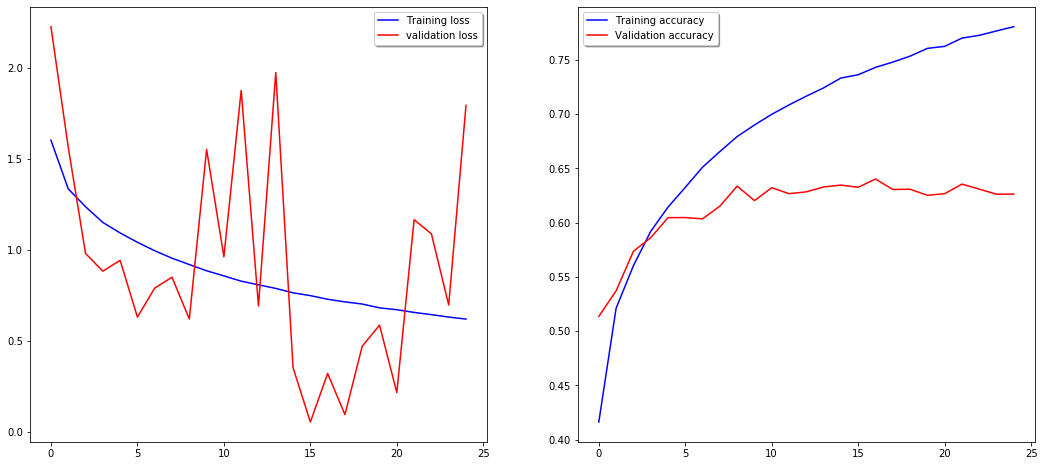

In [22]:
loss_acc_plt(history)